In [1]:
import pandas as pd


In [2]:
import yfinance as yf
def get_symbol_price(ticker,deltaT,symbol,startdate,enddate):
    symbol_history = ticker.history(start=startdate, end=enddate,interval = deltaT)
    symbol_close = symbol_history['Close']
    symbol_close.columns = symbol
    return symbol_close
def get_tickers(symbol_list):
    tickers  = {}
    for symbol in symbol_list:
        if symbol != " ":
            ticker = yf.Ticker(symbol)
            tickers[symbol] = ticker
    return tickers
def get_excel(dataframe, name):
    dataframe.dropna().to_excel(name, index=True)

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
import sklearn as sk
from sklearn.linear_model import Lasso
import seaborn as sns
from arch import arch_model
import statsmodels.tsa.vector_ar.vecm as vecm
from sklearn.linear_model import Ridge
import itertools
from scipy.stats import norm
# endregion
class cointegration():
    def __init__(self,stocklist,stockdata):
        self.stocklist = stocklist
        self.stockdata = stockdata
    def stationary_test(self):
        returnseries = np.log(self.stockdata/self.stockdata.shift(1))
        returnseries = returnseries.dropna(axis = 0)
        for symbol in self.stocklist:
            result1 = sm.tsa.stattools.adfuller(returnseries[symbol])
            if result1[1]>0.05:
                self.stocklist.remove(symbol)
                self.stockdata = self.stockdata.drop(symbol,axis = 1)
        new_stocklist = self.stocklist
        new_stockseries = self.stockdata
        return new_stocklist
    def pairs(self,stocklist):
        combination = list(itertools.combinations(stocklist, 2))
        return combination
    def machine_learning(self,Y,X,method):
        outcome = pd.DataFrame(columns = ["model.intercept","model.coef","residuals"])
        if method  == "OLS":
            model = sm.OLS(Y,sm.add_constant(X)).fit()
            model.summary()
            residuals = Y - model.params[0]- model.params[1]* X
            result = sm.tsa.stattools.adfuller(residuals)
            residuals_series = pd.Series(residuals)
            outcome["residuals"] = residuals_series
            outcome["model.intercept"].fillna(model.params[0],inplace = True)
            outcome["model.coef"].fillna(model.params[1],inplace = True)
        if method ==  "ridge":
            ridge = Ridge(alpha = 0.5,fit_intercept = True,normalize = True)
            model = ridge.fit(X.values.reshape(-1,1),Y.values.reshape(-1,1))
            residuals = Y.values.reshape(-1,1)- model.intercept_- model.coef_* X.values.reshape(-1,1)
            residuals_series = pd.Series(residuals.reshape(-1))
            outcome["residuals"] = residuals_series
            outcome["model.intercept"].fillna(model.intercept_.item(),inplace = True)
            outcome["model.coef"].fillna(model.coef_.item(),inplace = True)
        if method == "VECM":
            datapairs = pd.concat([Y,X],axis = 1)
            datapairs = np.log(datapairs)
            lag_order = vecm.select_order(data=datapairs, maxlags=10, deterministic="ci")
            rank = vecm.select_coint_rank(datapairs,det_order=0, k_ar_diff=lag_order.aic, method='trace', signif=0.05)
            model = vecm.VECM(datapairs, k_ar_diff=lag_order.aic, coint_rank=rank.rank, deterministic='ci')
            result =  model.fit()
            result.summary()
            residuals = Y + result.const_coint.item() + result.beta[1].item()* X
            outcome["residuals"] = residuals
            outcome["model.intercept"].fillna(result.const_coint.item(),inplace = True)
            outcome["model.coef"].fillna(result.beta[1].item(),inplace = True)
        return outcome
    def data_signal(self,outcome):
        resid_mean = np.mean(outcome["residuals"])
        resid_std = np.std(outcome["residuals"])
        lower50,upper50 = norm.interval(0.5,loc = resid_mean,scale = resid_std)
        lower80,upper80 = norm.interval(0.8,loc = resid_mean,scale = resid_std)
        lower90,upper90 = norm.interval(0.9,loc = resid_mean,scale = resid_std)
        breakpoints = [lower90,upper90]
        short_large_long_small = [upper80,upper50]
        long_large_short_small = [lower80,lower50]
        return breakpoints,short_large_long_small,long_large_short_small

In [15]:
startdate = dt.datetime(2020,6,26)
enddate = dt.datetime(2023,6,26)
raw = pd.read_excel(r'D:\stock\Screener Results3.xlsx')
stocklist = list(raw['Symbol'])
stockdata = pd.DataFrame(columns = stocklist)
tickers = get_tickers(stocklist)
for symbol in stocklist:
    tickers = get_tickers(stocklist)
    symbol_close = get_symbol_price(tickers[symbol],"1d",symbol,startdate,enddate)
    stockdata[symbol] = symbol_close
print(stockdata)

- CORR_PA: No data found, symbol may be delisted
                COHN      LUMN      CORR      SQFT       PVL        HPP  \
Date                                                                      
2020-06-25  8.301785  8.308203  8.179632       NaN  0.956746  20.523779   
2020-06-26  8.214894  7.869623  7.670599       NaN  0.979708  20.639828   
2020-06-29  6.737794  8.101325  8.460479       NaN  0.929034  20.822191   
2020-06-30  7.440799  8.299928  8.030431       NaN  0.921356  20.855347   
2020-07-01  7.756757  8.167526  7.617941       NaN  0.921356  20.963102   
...              ...       ...       ...       ...       ...        ...   
2023-06-16  4.600588  2.250000  1.210000  0.846375  2.393538   4.850000   
2023-06-20  4.066765  2.110000  1.170000  0.826919  2.364229   4.820000   
2023-06-21  4.076470  1.940000  1.150000  0.832756  2.413077   4.750000   
2023-06-22  3.930882  1.850000  1.160000  0.880425  2.403307   4.410000   
2023-06-23  3.930882  1.820000  1.040000  0.824000 

In [5]:
print(stockdata)
stockdataA = stockdata.dropna(axis = 1)
stocklistA = list(stockdataA.columns)
print(stockdataA)



                COHN      LUMN      CORR      SQFT       PVL        HPP  \
Date                                                                      
2020-06-25  8.553354  8.308202  8.179632       NaN  0.956746  20.523785   
2020-06-26  8.463831  7.869624  7.670598       NaN  0.979708  20.639828   
2020-06-29  6.941970  8.101325  8.460478       NaN  0.929034  20.822189   
2020-06-30  7.666278  8.299928  8.030432       NaN  0.921356  20.855345   
2020-07-01  7.991811  8.167526  7.617939       NaN  0.921356  20.963102   
...              ...       ...       ...       ...       ...        ...   
2023-06-16  4.740000  2.250000  1.210000  0.846375  2.393538   4.850000   
2023-06-20  4.190000  2.110000  1.170000  0.826919  2.364229   4.820000   
2023-06-21  4.200000  1.940000  1.150000  0.832756  2.413077   4.750000   
2023-06-22  4.050000  1.850000  1.160000  0.880425  2.403307   4.410000   
2023-06-23  4.050000  1.820000  1.040000  0.824000  2.413077   4.080000   

                OXSQ   C

In [6]:
stockseries = stockdataA
pairs_trade = cointegration(stocklistA,stockseries)
new_stocklist = pairs_trade.stationary_test()
pairs = pairs_trade.pairs(new_stocklist)
new_pair = []
print(pairs)
for pair in pairs:
    result = sm.tsa.stattools.coint(stockseries[pair[0]],stockseries[pair[1]])
    print(result[1])
    print(pair)
    if result[1]<0.05:
        new_pair.append(pair)
print(new_pair)


[('COHN', 'LUMN'), ('COHN', 'CORR'), ('COHN', 'PVL'), ('COHN', 'HPP'), ('COHN', 'OXSQ'), ('COHN', 'ENDTF'), ('COHN', 'LFT'), ('COHN', 'VOC'), ('COHN', 'BDN'), ('COHN', 'PDM'), ('COHN', 'AAIC'), ('COHN', 'RWT'), ('COHN', 'CHI'), ('COHN', 'DSX'), ('COHN', 'IGR'), ('COHN', 'AMKBY'), ('COHN', 'NRO'), ('COHN', 'CULP'), ('COHN', 'IDE'), ('COHN', 'EXG'), ('COHN', 'DNIF'), ('COHN', 'SPE'), ('COHN', 'DLAKY'), ('COHN', 'BKCC'), ('COHN', 'AOD'), ('COHN', 'ACP'), ('COHN', 'CGO'), ('COHN', 'FOF'), ('COHN', 'USA'), ('COHN', 'NCV'), ('COHN', 'LKHLY'), ('COHN', 'UFGSY'), ('COHN', 'GEGYY'), ('COHN', 'KIROY'), ('COHN', 'GOGL'), ('COHN', 'SACH'), ('COHN', 'AGD'), ('COHN', 'ERELY'), ('COHN', 'MNDJF'), ('COHN', 'EOD'), ('COHN', 'PRT'), ('COHN', 'GMRE'), ('COHN', 'AGNC'), ('COHN', 'GGT'), ('COHN', 'GLO'), ('LUMN', 'CORR'), ('LUMN', 'PVL'), ('LUMN', 'HPP'), ('LUMN', 'OXSQ'), ('LUMN', 'ENDTF'), ('LUMN', 'LFT'), ('LUMN', 'VOC'), ('LUMN', 'BDN'), ('LUMN', 'PDM'), ('LUMN', 'AAIC'), ('LUMN', 'RWT'), ('LUMN', 'CHI

0.12617427308675933
('COHN', 'LFT')
0.04814266157271527
('COHN', 'VOC')
0.08234554063684818
('COHN', 'BDN')
0.05214751193803376
('COHN', 'PDM')
0.7390901168205523
('COHN', 'AAIC')
0.5641952766604552
('COHN', 'RWT')
0.6870727165198239
('COHN', 'CHI')
0.5378687273111592
('COHN', 'DSX')
0.6360957620779143
('COHN', 'IGR')
0.6994509473926906
('COHN', 'AMKBY')
0.5134330073975436
('COHN', 'NRO')
0.0319227289512524
('COHN', 'CULP')
0.7523650534305075
('COHN', 'IDE')
0.7494903763515316
('COHN', 'EXG')
0.7275327270067437
('COHN', 'DNIF')
0.7294380748053364
('COHN', 'SPE')
0.5423961306305604
('COHN', 'DLAKY')
0.5682391838252606
('COHN', 'BKCC')
0.7513736034063536
('COHN', 'AOD')
0.22864789908247324
('COHN', 'ACP')
0.1388339527743202
('COHN', 'CGO')
0.7325829856638537
('COHN', 'FOF')
0.730536664374735
('COHN', 'USA')
0.29584432174252073
('COHN', 'NCV')
3.641093392782806e-05
('COHN', 'LKHLY')
0.6642604895690798
('COHN', 'UFGSY')
0.3976944706728389
('COHN', 'GEGYY')
0.3014313111121565
('COHN', 'KIRO

0.6606647241722532
('OXSQ', 'UFGSY')
0.25531889935406293
('OXSQ', 'GEGYY')
0.3157096971670933
('OXSQ', 'KIROY')
0.7808280213883888
('OXSQ', 'GOGL')
0.3061200993469016
('OXSQ', 'SACH')
0.7481828695534
('OXSQ', 'AGD')
0.29938361241813155
('OXSQ', 'ERELY')
0.0652490159248767
('OXSQ', 'MNDJF')
0.390494730225603
('OXSQ', 'EOD')
0.605983957894389
('OXSQ', 'PRT')
0.6703302691736399
('OXSQ', 'GMRE')
0.6824706421360138
('OXSQ', 'AGNC')
0.37743398268719053
('OXSQ', 'GGT')
0.6131060486275944
('OXSQ', 'GLO')
0.5173546198127779
('ENDTF', 'LFT')
0.21378343412111178
('ENDTF', 'VOC')
0.3835463862529912
('ENDTF', 'BDN')
0.3939891707198091
('ENDTF', 'PDM')
0.4452478828268788
('ENDTF', 'AAIC')
0.7475125472342483
('ENDTF', 'RWT')
0.8219506282539808
('ENDTF', 'CHI')
0.026743674869962604
('ENDTF', 'DSX')
0.9167075873781143
('ENDTF', 'IGR')
0.4430453568359587
('ENDTF', 'AMKBY')
0.859422417334251
('ENDTF', 'NRO')
0.06767414382687319
('ENDTF', 'CULP')
0.8611733736690577
('ENDTF', 'IDE')
0.8434078723974578
('EN

0.656620846092837
('RWT', 'CULP')
0.4701746518276379
('RWT', 'IDE')
0.46968871163315157
('RWT', 'EXG')
0.7465341611047493
('RWT', 'DNIF')
0.39073520634530434
('RWT', 'SPE')
0.7211547632741138
('RWT', 'DLAKY')
0.837701309494973
('RWT', 'BKCC')
0.5875522278436117
('RWT', 'AOD')
0.2001900793073948
('RWT', 'ACP')
0.15866542727514255
('RWT', 'CGO')
0.21017414628252157
('RWT', 'FOF')
0.2873619208106941
('RWT', 'USA')
0.3305075558483956
('RWT', 'NCV')
0.3188899197967551
('RWT', 'LKHLY')
0.8092200721183731
('RWT', 'UFGSY')
0.37450486831465957
('RWT', 'GEGYY')
0.42248269075553774
('RWT', 'KIROY')
0.8000906791792939
('RWT', 'GOGL')
0.04045126710887077
('RWT', 'SACH')
0.35941776961971406
('RWT', 'AGD')
0.6755785164260265
('RWT', 'ERELY')
0.3985083553776265
('RWT', 'MNDJF')
0.6738270520796436
('RWT', 'EOD')
0.7675345303369789
('RWT', 'PRT')
0.27545177083320027
('RWT', 'GMRE')
0.6175338682138993
('RWT', 'AGNC')
0.4866233351527083
('RWT', 'GGT')
0.427754754925127
('RWT', 'GLO')
0.4357791477476379
('

0.6881460743391703
('EXG', 'CGO')
0.04188971029303216
('EXG', 'FOF')
0.00036032861537352225
('EXG', 'USA')
0.717356629455797
('EXG', 'NCV')
0.30566130907653477
('EXG', 'LKHLY')
0.10918906301998049
('EXG', 'UFGSY')
0.24430891615602118
('EXG', 'GEGYY')
0.3513233359274246
('EXG', 'KIROY')
0.5285684393654532
('EXG', 'GOGL')
0.06259994920549157
('EXG', 'SACH')
0.07323468146545159
('EXG', 'AGD')
0.261175960497684
('EXG', 'ERELY')
0.19216351204996968
('EXG', 'MNDJF')
0.1671653690288029
('EXG', 'EOD')
0.5127320776864177
('EXG', 'PRT')
0.5399951550953361
('EXG', 'GMRE')
0.49786544061020377
('EXG', 'AGNC')
0.2796924055847234
('EXG', 'GGT')
0.509442971914505
('EXG', 'GLO')
0.6149868478749194
('DNIF', 'SPE')
0.5181313613999036
('DNIF', 'DLAKY')
0.2844878778278235
('DNIF', 'BKCC')
0.1676653498317467
('DNIF', 'AOD')
0.813404752324793
('DNIF', 'ACP')
0.7293535352861504
('DNIF', 'CGO')
0.26078218214322213
('DNIF', 'FOF')
0.09491423833963769
('DNIF', 'USA')
0.7434318854130092
('DNIF', 'NCV')
0.45436163

0.6396090662374814
('UFGSY', 'PRT')
0.844063094811518
('UFGSY', 'GMRE')
0.7968723784855043
('UFGSY', 'AGNC')
0.6018265019700335
('UFGSY', 'GGT')
0.8005468424409179
('UFGSY', 'GLO')
0.02372275661159925
('GEGYY', 'KIROY')
0.06791791623495708
('GEGYY', 'GOGL')
0.01862797405338275
('GEGYY', 'SACH')
0.038950848954557526
('GEGYY', 'AGD')
0.06631458453628292
('GEGYY', 'ERELY')
0.005554398892526898
('GEGYY', 'MNDJF')
0.056116208406319194
('GEGYY', 'EOD')
0.06890070432476349
('GEGYY', 'PRT')
0.013535600823241388
('GEGYY', 'GMRE')
0.038764689165082473
('GEGYY', 'AGNC')
0.009308720864008165
('GEGYY', 'GGT')
0.03154941968599234
('GEGYY', 'GLO')
0.224340025344753
('KIROY', 'GOGL')
0.15978342733126216
('KIROY', 'SACH')
0.1016065769685372
('KIROY', 'AGD')
0.17661892591170902
('KIROY', 'ERELY')
0.009520311071138191
('KIROY', 'MNDJF')
0.18603185817013485
('KIROY', 'EOD')
0.22411500379829496
('KIROY', 'PRT')
0.09806619703349645
('KIROY', 'GMRE')
0.07542754189293242
('KIROY', 'AGNC')
0.029241363342387628

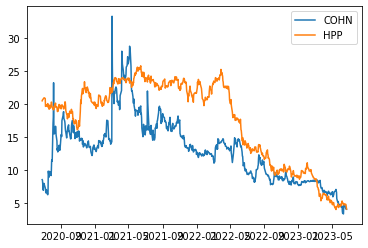

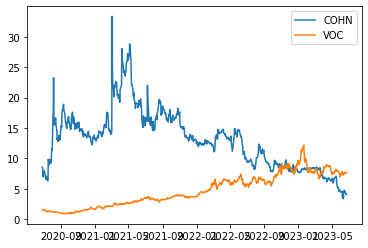

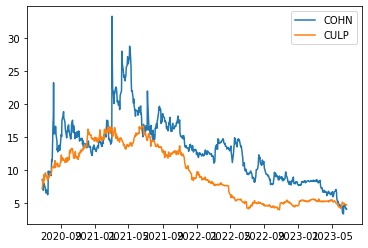

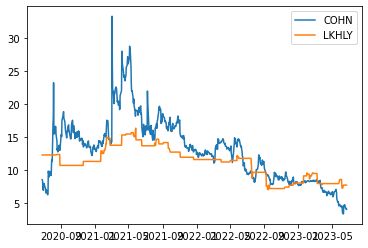

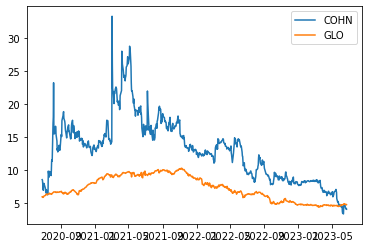

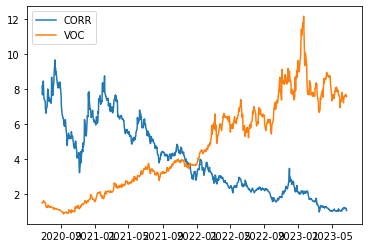

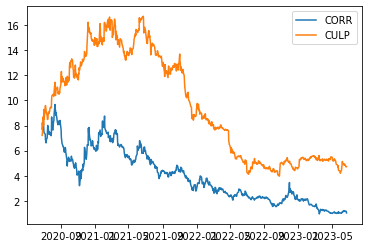

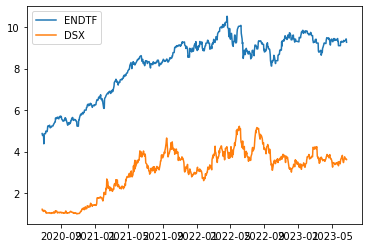

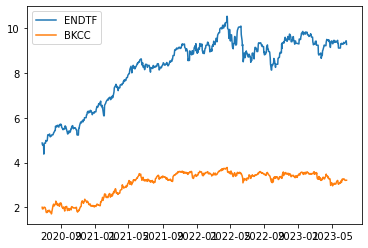

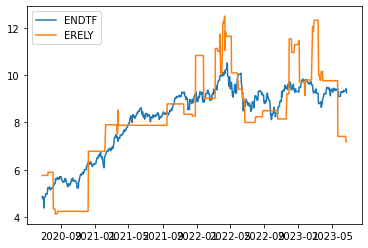

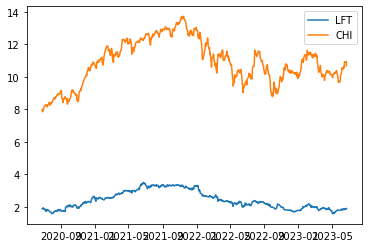

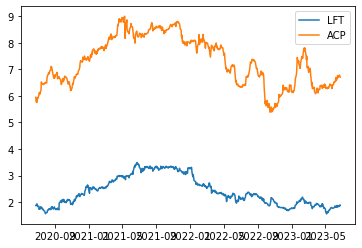

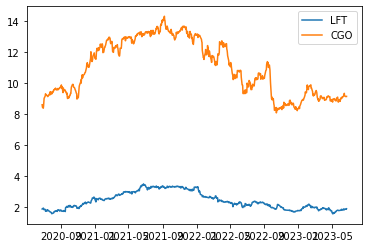

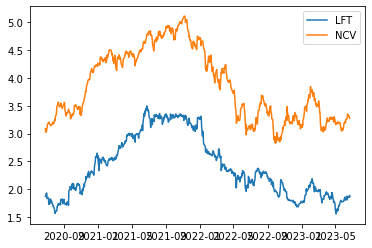

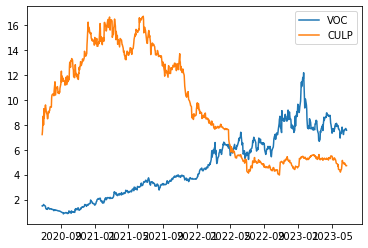

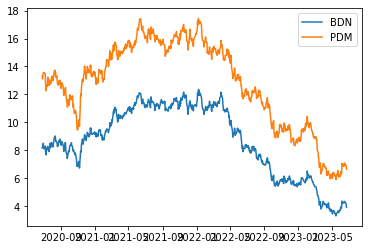

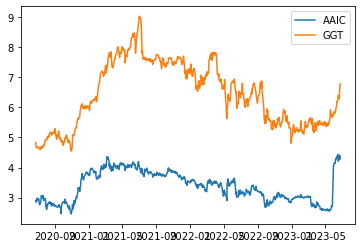

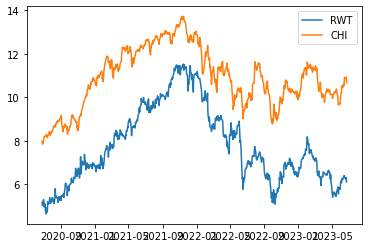

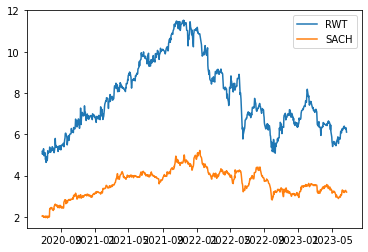

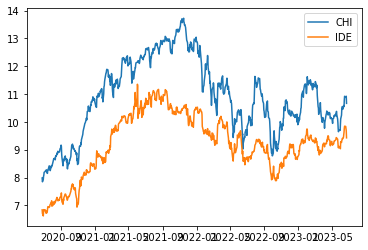

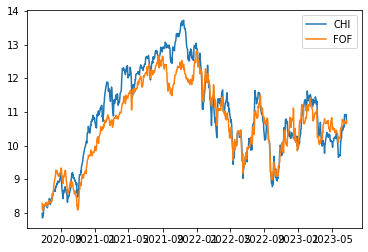

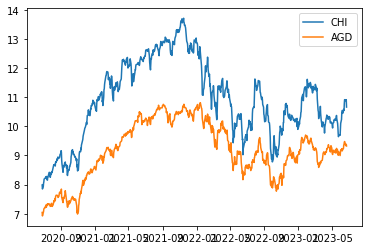

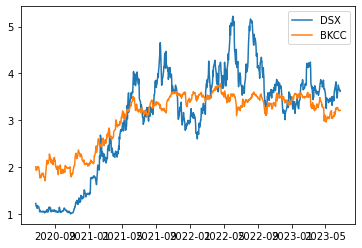

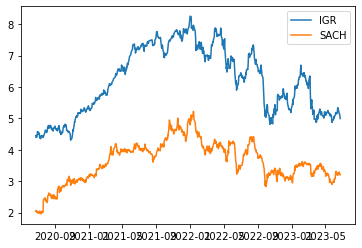

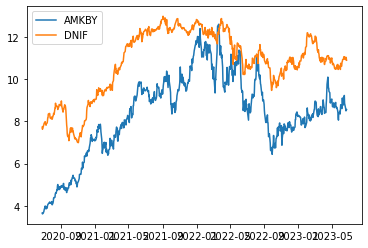

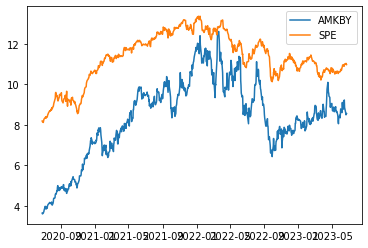

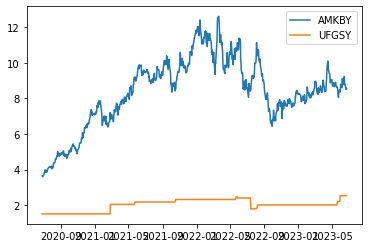

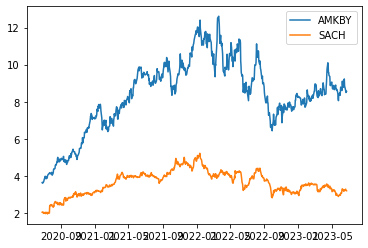

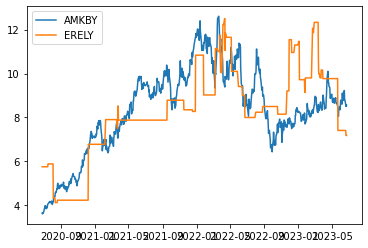

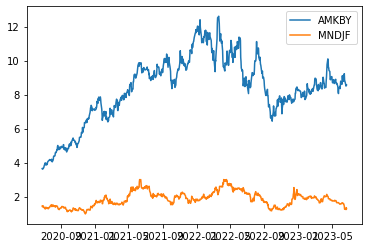

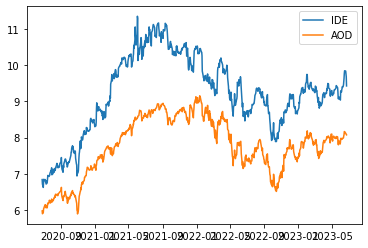

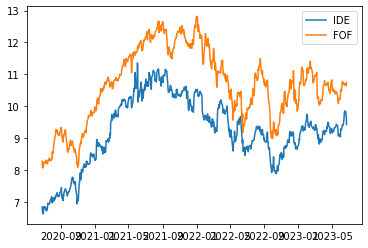

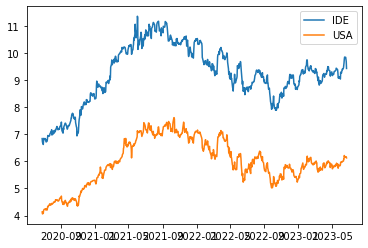

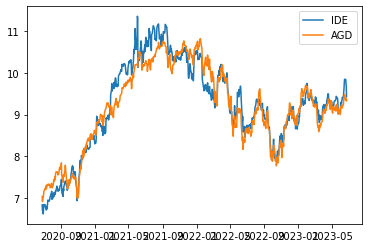

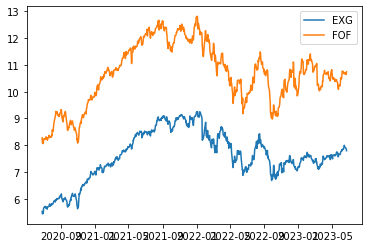

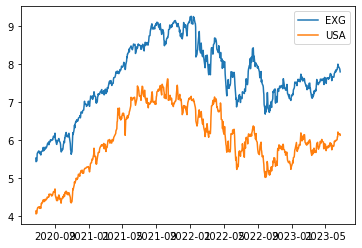

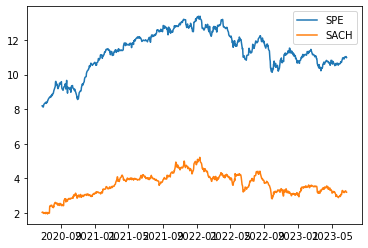

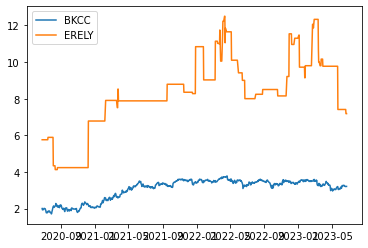

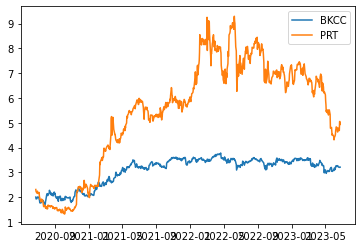

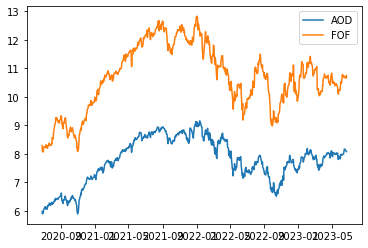

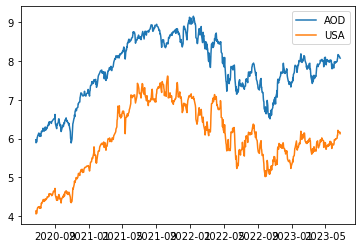

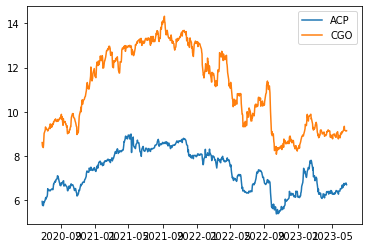

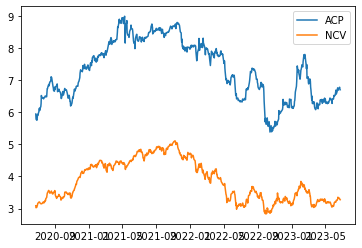

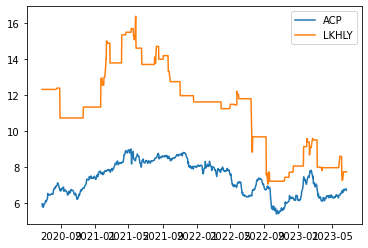

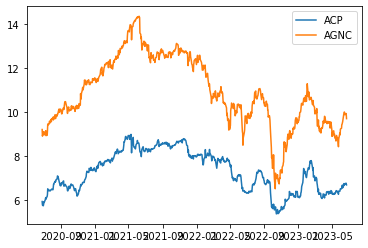

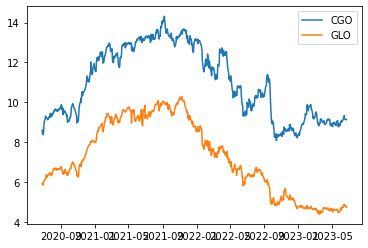

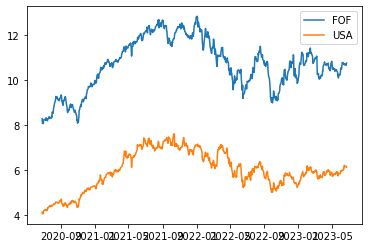

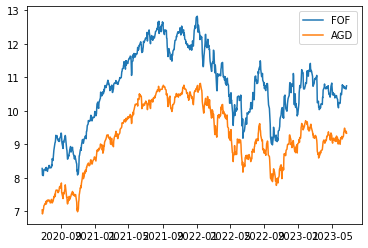

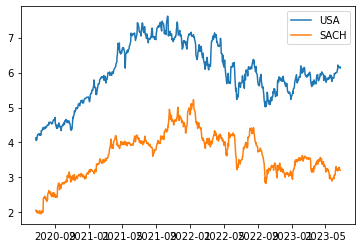

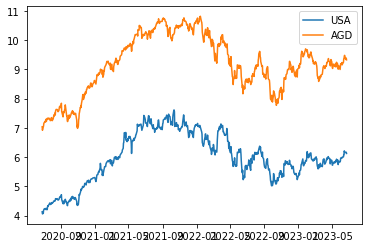

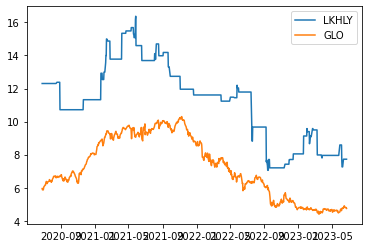

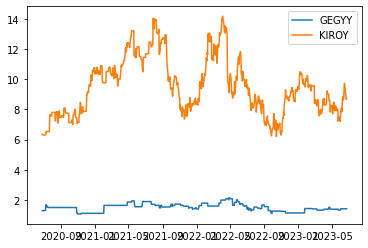

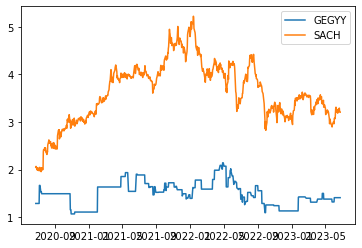

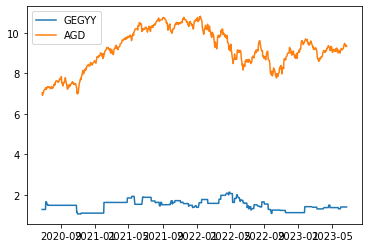

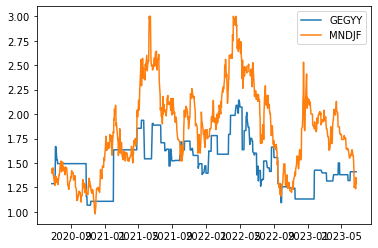

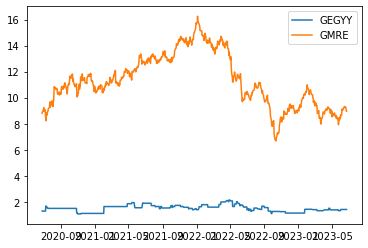

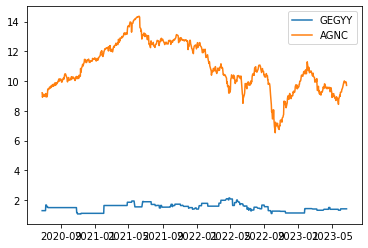

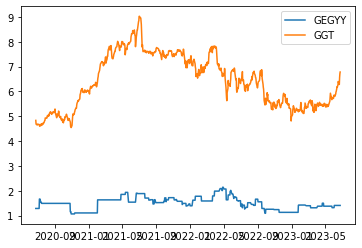

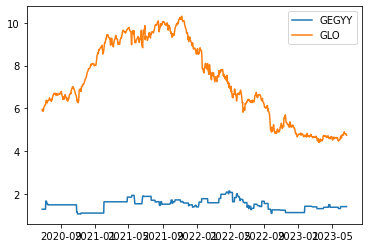

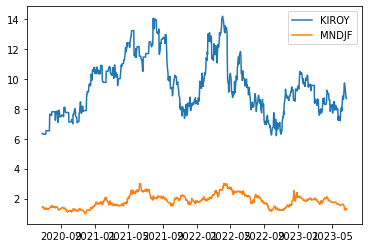

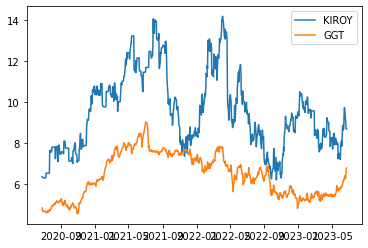

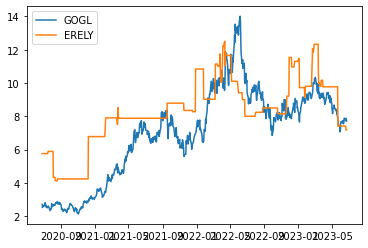

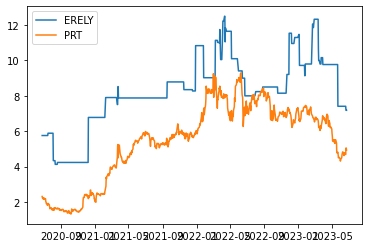

In [7]:
#[('DEN', 'BCHEY'), ('EOG', 'BTU')]
for pair in new_pair:
    plt.plot(stockseries[pair[0]],label = pair[0])
    plt.plot(stockseries[pair[1]],label = pair[1])
    plt.legend()
    plt.show()

               GEGYY  MNDJF      KIROY       GGT
Date                                            
2021-07-15  1.886941   2.44  11.771426  7.603296
2021-07-16  1.886941   2.33  11.771426  7.603296
2021-07-19  1.886941   2.20  11.771426  7.634910
2021-07-20  1.886941   2.04  11.771426  7.650720
2021-07-21  1.886941   2.07  11.573031  7.658621
...              ...    ...        ...       ...
2023-07-10  1.220000   1.34   7.133663  6.660000
2023-07-11  1.220000   1.50   7.209251  6.780000
2023-07-12  1.220000   1.51   7.728922  6.650000
2023-07-13  1.220000   1.46   7.832856  6.700000
2023-07-14  1.220000   1.38   7.851754  6.680000

[503 rows x 4 columns]


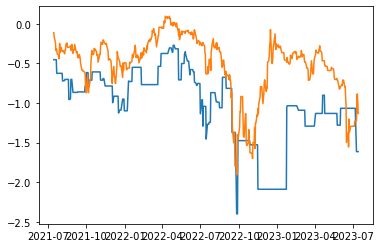

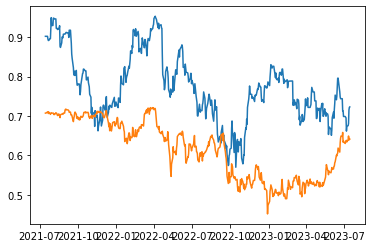

In [4]:
#可交易配对肉眼：(GEGYY AND MNDJF) (KIROY AND GGT) (ERELY AND PRT)
select_pair = [('GEGYY','MNDJF'),('KIROY','GGT')]
stocklist= ['GEGYY','MNDJF','KIROY','GGT']
startdate = dt.datetime(2021,7,16)
enddate = dt.datetime(2023,7,16)
stockdata = pd.DataFrame(columns = stocklist)
tickers = get_tickers(stocklist)
for symbol in stocklist:
    tickers = get_tickers(stocklist)
    symbol_close = get_symbol_price(tickers[symbol],"1d",symbol,startdate,enddate)
    stockdata[symbol] = symbol_close
print(stockdata)
stockdata = np.log(stockdata)
for pair in select_pair:
    testlist = []
    testlist.append(pair[0])
    testlist.append(pair[1])
    datasample = np.log(stockdata[testlist])
    plt.plot(datasample)
    plt.show()


--------
('GEGYY', 'MNDJF')
            model.intercept  model.coef  residuals
Date                                              
2020-06-25         0.843083    0.356744  -0.068078
2020-06-26         0.843083    0.356744  -0.052382
2020-06-29         0.843083    0.356744  -0.072003
2020-06-30         0.843083    0.356744  -0.047030
2020-07-01         0.843083    0.356744  -0.047030
...                     ...         ...        ...
2023-06-16         0.843083    0.356744   0.120986
2023-06-20         0.843083    0.356744   0.106717
2023-06-21         0.843083    0.356744   0.126338
2023-06-22         0.843083    0.356744   0.085312
2023-06-23         0.843083    0.356744   0.106717

[754 rows x 3 columns]
有仓位全部清空


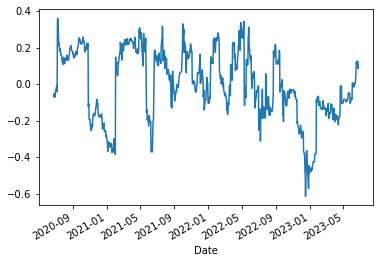

--------
('KIROY', 'GGT')
            model.intercept  model.coef  residuals
Date                                              
2020-06-25         1.414987    1.177111  -1.099502
2020-06-26         1.414987    1.177111  -0.922747
2020-06-29         1.414987    1.177111  -0.941990
2020-06-30         1.414987    1.177111  -0.933572
2020-07-01         1.414987    1.177111  -0.975658
...                     ...         ...        ...
2023-06-16         1.414987    1.177111   0.235501
2023-06-20         1.414987    1.177111  -0.294093
2023-06-21         1.414987    1.177111  -0.859898
2023-06-22         1.414987    1.177111  -1.112053
2023-06-23         1.414987    1.177111  -1.194451

[754 rows x 3 columns]
有仓位全部清空


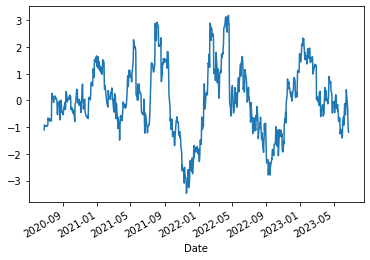

In [16]:
pairs_trade = cointegration(stocklist,stockdata)
end_date = dt.date.today()
start_date = end_date - dt.timedelta(60)
rollingwindow = {}
for pair in select_pair:
    outcome = pairs_trade.machine_learning(stockdata[pair[0]],stockdata[pair[1]],'OLS')
    print("--------")
    print(pair)
    mu = np.mean(outcome['residuals'])
    std = np.std(outcome['residuals'])
    print(outcome)
    rollingwindow[pair[0]] = get_symbol_price(tickers[pair[0]],"1d",symbol,start_date,end_date)
    rollingwindow[pair[1]] = get_symbol_price(tickers[pair[1]],"1d",symbol,start_date,end_date)
    logpricey = np.log(rollingwindow[pair[0]][-1])
    logpricex = np.log(rollingwindow[pair[1]][-1])
    residual = logpricey+outcome.iloc[1,1]*logpricex+outcome.iloc[1,0]
    if residual>mu+1.3*std and residual< mu+2.5*std:
        print("卖空"+pair[0]+"股票:")
        print(500*outcome.iloc[1,1])
        print("买入"+pair[1]+"股票:")
        print(500)
    elif residual<mu-1.3*std and residual>mu-2.5*std:
        print("卖空"+pair[1]+"股票:")
        print(500*outcome.iloc[1,1])
        print("买入"+pair[0]+"股票:")
        print(500)
    else:
        print("有仓位全部清空")
    outcome['residuals'].plot()
    #plt.axhline(y = mu,color = 'black')
    #plt.axhline(y = mu+0.2*std,color = 'blue',ls = '-',lw = 2)
    #plt.axhline(y = mu-0.2*std,color = 'blue',ls = '-',lw = 2)
    #plt.axhline(y = mu+1.3*std,color = 'green',ls = '--',lw = 2.5)
    #plt.axhline(y = mu-1.3*std,color = 'green',ls = '--',lw = 2.5)
    #plt.axhline(y = mu+2.5*std,color = 'red',ls = '-.',lw = 3)
    #plt.axhline(y = mu-2.5*std,color = 'red',ls = '-.',lw = 3)
    plt.show()
    

In [14]:
for pair in select_pair:
    newstocklist = []
    newstocklist.append(pair[0])
    newstocklist.append(pair[1])
    datapairs = stockdata[newstocklist]
    print(datapairs)
    lag_order = vecm.select_order(data=datapairs, maxlags=10, deterministic="ci")
    rank = vecm.select_coint_rank(datapairs,det_order=0, k_ar_diff=lag_order.aic, method='trace', signif=0.05)
    model = vecm.VECM(datapairs, k_ar_diff=lag_order.aic, coint_rank=rank.rank, deterministic='ci')
    print("lag_order.aic")
    print(lag_order.aic)
    print("rank.rank")
    print(rank.rank)
    result =  model.fit()
    result.summary()
    print(result.beta[1].item())
    print(result.const_coint.item())
    

               GEGYY     MNDJF
Date                          
2021-07-15  0.634957  0.891998
2021-07-16  0.634957  0.845868
2021-07-19  0.634957  0.788457
2021-07-20  0.634957  0.712950
2021-07-21  0.634957  0.727549
...              ...       ...
2023-07-10  0.198851  0.292670
2023-07-11  0.198851  0.405465
2023-07-12  0.198851  0.412110
2023-07-13  0.198851  0.378436
2023-07-14  0.198851  0.322083

[503 rows x 2 columns]
lag_order.aic
1
rank.rank
1
-0.7138638991711416
0.06600781894824465
               KIROY       GGT
Date                          
2021-07-15  2.522398  2.028582
2021-07-16  2.522398  2.028582
2021-07-19  2.522398  2.032731
2021-07-20  2.522398  2.034800
2021-07-21  2.505400  2.035832
...              ...       ...
2023-07-10  2.021548  1.896119
2023-07-11  2.032088  1.913977
2023-07-12  2.101692  1.894617
2023-07-13  2.115050  1.902107
2023-07-14  2.117460  1.899118

[503 rows x 2 columns]
lag_order.aic
3
rank.rank
0


C:\Users\pastone\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pastone\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pastone\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pastone\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

ValueError: shapes (0,2) and (3,499) not aligned: 2 (dim 1) != 3 (dim 0)